# DoWhy: Different estimation methods for causal inference
This is a quick introduction to the DoWhy causal inference library.
We will load in a sample dataset and use different methods for estimating the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable.

First, let us add the required path for Python to find the DoWhy code and load all required packages

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome. 

Beta is the true causal effect. 

In [3]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5, 
        num_instruments = 2,
        num_samples=10000,
        treatment_is_binary=True)
df = data["df"]

Note that we are using a pandas dataframe to load the data.

## Identifying the causal estimand

We now input a causal graph in the DOT graph format.

In [4]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"],
        logging_level = logging.INFO
        )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


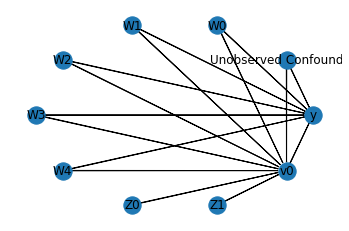

In [5]:
model.view_model()

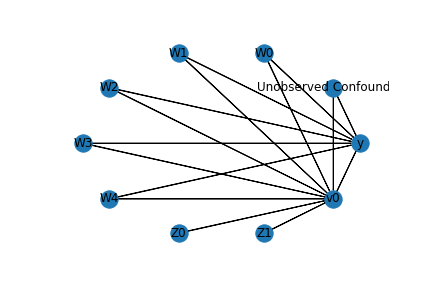

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done. 

In [7]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W2', 'W4', 'Unobserved Confounders', 'W0', 'W3', 'W1']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                
───(Expectation(y|W2,W4,W0,W3,W1))
dv₀                               
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)



## Method 1: Regression

Use linear regression.

In [8]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W4+W0+W3+W1


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                
───(Expectation(y|W2,W4,W0,W3,W1))
dv₀                               
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
b: y~v0+W2+W4+W0+W3+W1
## Estimate
Value: 9.999999999999693

## Statistical Significance
p-value: <0.001

Causal Estimate is 9.999999999999693


## Method 2: Stratification

We will be using propensity scores to stratify units in the data.

In [9]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W4+W0+W3+W1
/home/amit/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                
───(Expectation(y|W2,W4,W0,W3,W1))
dv₀                               
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
b: y~v0+W2+W4+W0+W3+W1
## Estimate
Value: 10.023434125219422

Causal Estimate is 10.023434125219422


## Method 3: Matching

We will be using propensity scores to match units in the data.

In [10]:
causal_estimate_match = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W4+W0+W3+W1
/home/amit/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/c/Users/amshar/code/dowhy/dowhy/causal_estimators/propensity_score_matching_estimator.py:62: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                
───(Expectation(y|W2,W4,W0,W3,W1))
dv₀                               
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
b: y~v0+W2+W4+W0+W3+W1
## Estimate
Value: 16.567950719540818

Causal Estimate is 16.567950719540818


## Method 4: Weighting

We will be using (inverse) propensity scores to assign weights to units in the data. DoWhy supports a few different weighting schemes:
1. Vanilla Inverse Propensity Score weighting (IPS)
2. Self-normalized IPS weighting (also known as the Hajek estimator)
3. Stabilized IPS weighting

In [11]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting", method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W4+W0+W3+W1


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                
───(Expectation(y|W2,W4,W0,W3,W1))
dv₀                               
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
b: y~v0+W2+W4+W0+W3+W1
## Estimate
Value: 19.171266513511014

Causal Estimate is 19.171266513511014


/home/amit/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Method 5: Instrumental Variable

We will be using the Wald estimator for the provided instrumental variable.

In [12]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params={'iv_instrument_name':'Z0'})
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z1))⋅Expectation(Derivative(v0, Z1))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] isaffected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y isaffected in the same way by common causes of ['v0'] and y



*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                
───(Expectation(y|W2,W4,W0,W3,W1))
dv₀                               
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z1))⋅Expectation(Derivative(v0, Z1))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)
Estimand assumption 3, treatment_effect_h

## Method 6: Regression Discontinuity

We will be internally converting this to an equivalent instrumental variables problem.

In [13]:
causal_estimate_regdist = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity", 
        method_params={'rd_variable_name':'Z1',
                       'rd_threshold_value':0.5,
                       'rd_bandwidth': 0.1})
print(causal_estimate_regdist)
print("Causal Estimate is " + str(causal_estimate_regdist.value))

INFO:dowhy.causal_estimator:Using Regression Discontinuity Estimator
INFO:dowhy.causal_estimator:
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z1))⋅Expectation(Derivative(v0, Z1))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['local_treatment'] isaffected in the same way by common causes of ['local_treatment'] and local_outcome
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome local_outcome isaffected in the same way by common causes of ['local_treatment'] and local_outcome



*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                
───(Expectation(y|W2,W4,W0,W3,W1))
dv₀                               
Estimand assumption 1, Unconfoundedness: If U→v0 and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z1)/Derivative(v0, Z1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z1))⋅Expectation(Derivative(v0, Z1))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z1,Z0)
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→v0, then ¬(Z1,Z0→y)
Estimand assumption 3, treatment_effect_h